In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import scipy
import copy
import math
import time

#plotting with Cartopy. 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import cm
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker


# import scipy
from datetime import datetime
import os
# import utils
import importlib


# import statsmodels.api as sm
# from windspharm.xarray import VectorWind
# from windspharm.standard import VectorWind
# from windspharm.examples import example_data_path
# from windspharm.tools import prep_data, recover_data, order_latdim
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from shapely.geometry.polygon import LinearRing
from dask.diagnostics import ProgressBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import math
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import geocat.comp as gcomp
import shutil
import metpy.calc as mpcalc


ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/apps/opt/conda/envs/npl-2022b/share/proj failed



## Functions

In [2]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


def wgt_rmse(fld1, fld2, wgt):
    """Calculated the area-weighted RMSE.
    Inputs are 2-d spatial fields, fld1 and fld2 with the same shape.
    They can be xarray DataArray or numpy arrays.
    Input wgt is the weight vector, expected to be 1-d, matching length of one dimension of the data.
    Returns a single float value.
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.nansum(warray * (fld1 - fld2)**2)
        return np.sqrt( wmse ).item()

#######


## Dask

In [7]:
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')

client does not exist yet


In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(project='P54048000',walltime='06:00:00')
cluster.scale(40)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.61:40550,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
fns = sorted(glob.glob('/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_demo/atm/hist/*h1*'))
DS = xr.open_mfdataset(fns[96:466],parallel=True)

In [5]:
U = DS.sel(lat=15,lon=220,lev=850,method='nearest')['U'].load()
NU = DS.sel(lat=15,lon=220,lev=850,method='nearest')['Nudge_U'].load()
SU = DS.sel(lat=15,lon=220,lev=850,method='nearest')['Stochai_U'].load()

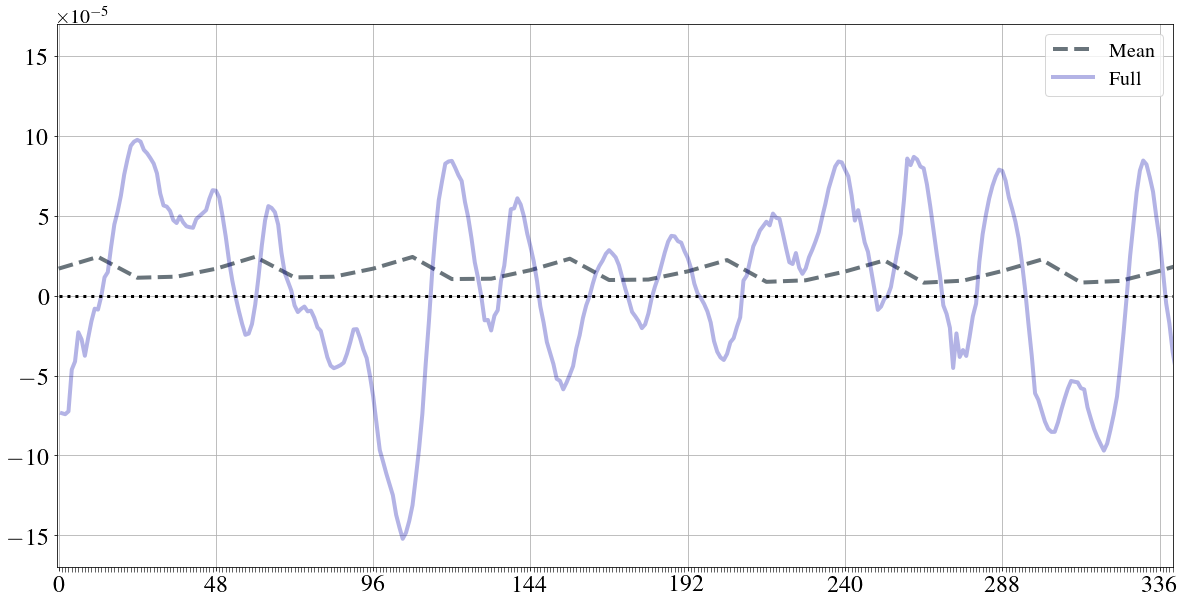

In [34]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(0,370),NU,linewidth=4,color='xkcd:slate grey',label='Mean',alpha=0.9,linestyle='--')
# ax.plot(np.arange(0,370),SU*0.8,linewidth=4,color='xkcd:red',label='Stochastic',alpha=0.7,linestyle='-.')
ax.plot(np.arange(1,370),np.diff(U)/1800,linewidth=4,alpha=0.3,color='xkcd:royal blue',label='Full')
ax.plot(np.arange(0,369),np.zeros([369,1]),linewidth=3,alpha=1,color='xkcd:black',linestyle=':')

# ax.plot([0,380],[11e-5,11e-5],linewidth=3,alpha=1,color='xkcd:black')
# for ii in range(8):
#     ax.plot(np.array([0,0])+60*ii,[11.4e-5,10.5e-5],linewidth=3,alpha=1,color='xkcd:black')
    
ax.set_xticks(np.arange(0,500,1))
# ax.set_xticklabels([])
ax.set_xticks(np.arange(0,500,48))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='minor', length=5, color='k')
ax.grid(True)
plt.ylim([-0.00017,0.00017])
# plt.yticks(np.arange(0,500,48))
plt.ticklabel_format(axis='y', style='sci', scilimits=(-5,-5))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.yaxis.offsetText.set_fontsize(20)
plt.xlim([-0.6,340])
plt.legend(fontsize=20)
### +++ saving
filepath = '/glade/work/wchapman/DA_ML/notebooks/Figures/Figure_output/'
plt.savefig(filepath +'/STOCHAI_Demo_Mean.png', dpi=200,bbox_inches='tight')
### --- saving
plt.show()

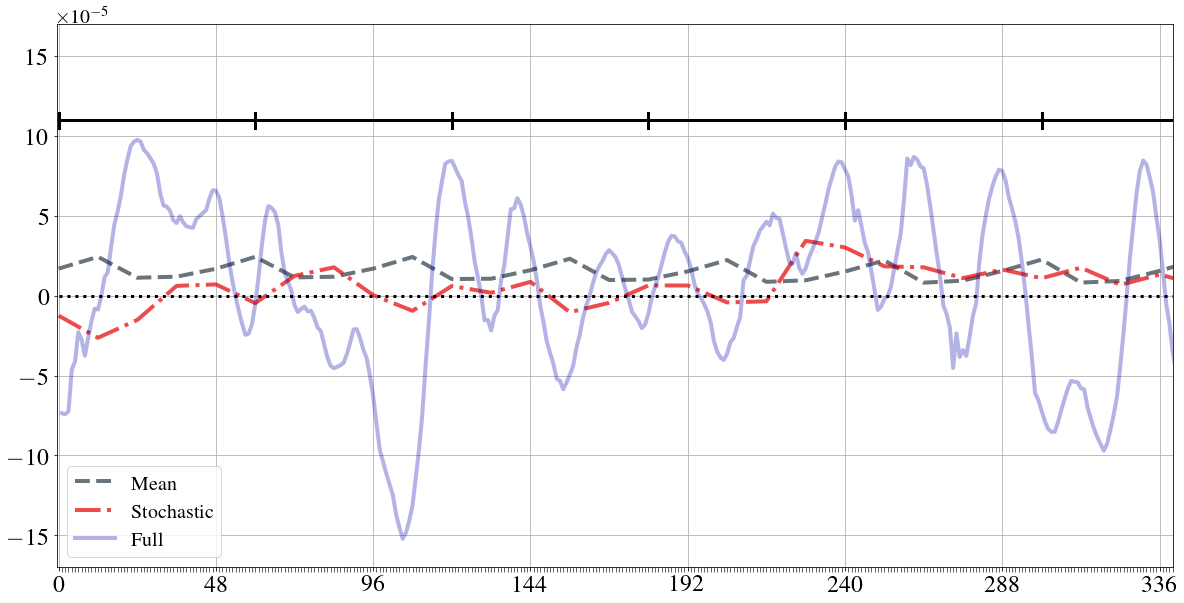

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(0,370),NU,linewidth=4,color='xkcd:slate grey',label='Mean',alpha=0.9,linestyle='--')
ax.plot(np.arange(0,370),SU*0.8,linewidth=4,color='xkcd:red',label='Stochastic',alpha=0.7,linestyle='-.')
ax.plot(np.arange(1,370),np.diff(U)/1800,linewidth=4,alpha=0.3,color='xkcd:royal blue',label='Full')
ax.plot(np.arange(0,369),np.zeros([369,1]),linewidth=3,alpha=1,color='xkcd:black',linestyle=':')

ax.plot([0,380],[11e-5,11e-5],linewidth=3,alpha=1,color='xkcd:black')
for ii in range(8):
    ax.plot(np.array([0,0])+60*ii,[11.4e-5,10.5e-5],linewidth=3,alpha=1,color='xkcd:black')
    
ax.set_xticks(np.arange(0,500,1))
# ax.set_xticklabels([])
ax.set_xticks(np.arange(0,500,48))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='minor', length=5, color='k')
ax.grid(True)
plt.ylim([-0.00017,0.00017])
# plt.yticks(np.arange(0,500,48))
plt.ticklabel_format(axis='y', style='sci', scilimits=(-5,-5))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.yaxis.offsetText.set_fontsize(20)
plt.xlim([-0.6,340])
plt.legend(fontsize=20)
### +++ saving
filepath = '/glade/work/wchapman/DA_ML/notebooks/Figures/Figure_output/'
plt.savefig(filepath +'/STOCHAI_Demo_Stochai.png', dpi=200,bbox_inches='tight')
### --- saving
plt.show()

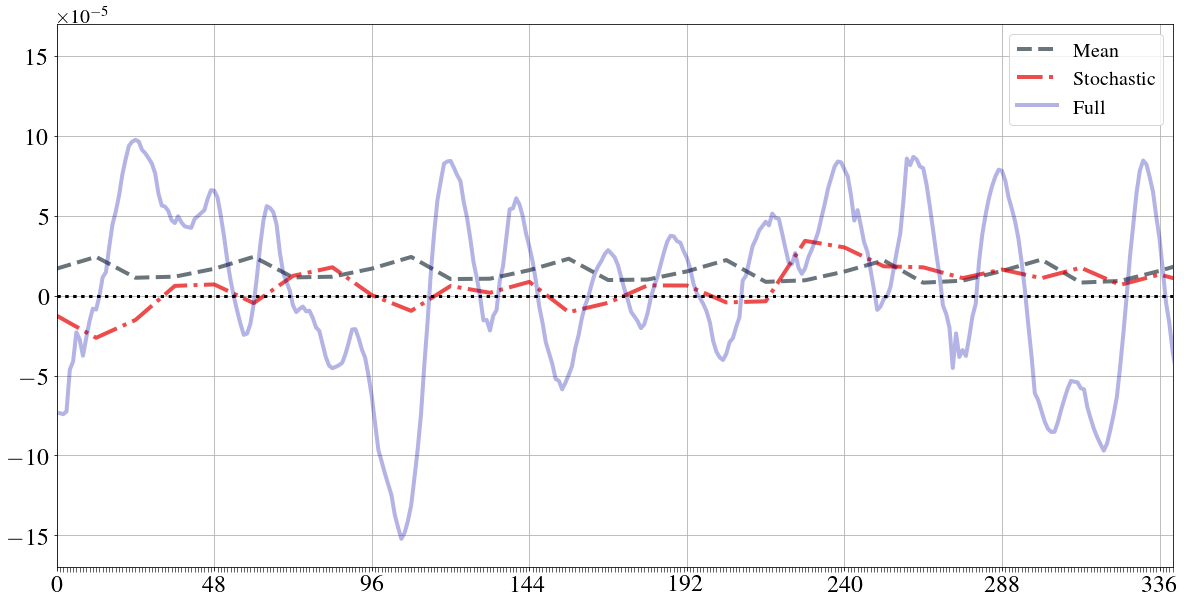

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(0,370),NU,linewidth=4,color='xkcd:slate grey',label='Mean',alpha=0.9,linestyle='--')
ax.plot(np.arange(0,370),SU*0.8,linewidth=4,color='xkcd:red',label='Stochastic',alpha=0.7,linestyle='-.')
ax.plot(np.arange(1,370),np.diff(U)/1800,linewidth=4,alpha=0.3,color='xkcd:royal blue',label='Full')
ax.plot(np.arange(0,369),np.zeros([369,1]),linewidth=3,alpha=1,color='xkcd:black',linestyle=':')


ax.plot(np.arange(0,369),np.zeros([369,1]),linewidth=3,alpha=1,color='xkcd:black',linestyle=':')



ax.set_xticks(np.arange(0,500,1))
# ax.set_xticklabels([])
ax.set_xticks(np.arange(0,500,48))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='minor', length=5, color='k')
ax.grid(True)
plt.ylim([-0.00017,0.00017])
# plt.yticks(np.arange(0,500,48))
plt.ticklabel_format(axis='y', style='sci', scilimits=(-5,-5))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax.yaxis.offsetText.set_fontsize(20)
plt.xlim([0,340])
plt.legend(fontsize=20)
plt.show()